<h1>Multi-Layer Perceptron (MLP) Model for Classification</h1>

<h3>Objective</h3>

The purpose of this notebook is to implement a Multi-Layer Perceptron (MLP) for classification tasks. The model is evaluated using k-fold cross-validation to ensure robust results.

<h3>Data Preparation</h3>
The dataset comprises keystroke dynamics data for multiple users.<br>
Keys of interest: ['T', 'A', 'E', 'I', 'H'].

Import required libraries

In [33]:
import os
import zipfile
import pandas as pd
import numpy as np
from datetime import datetime
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import setuptools.dist
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

Get the dataset

In [34]:
dataset_dir = '/Users/spartan/Documents/Information Security/Assignment 2/dataset'
dataset_files = os.listdir(dataset_dir)
print("Dataset Files:", dataset_files)

Dataset Files: ['54.csv', '55.csv', '57.csv', '56.csv', '52.csv', '53.csv', '51.csv', '60.csv', '58.csv', '59.csv']


<h3>Sliding Window Sampling</h3>
Overlapping samples are generated from the raw data.<br><br>
Parameters:<br>
Sample Size: 1000 rows.
Overlap: 75%.<br><br>
This technique ensures better feature representation by utilizing overlapping segments of the data.

Function to create overlapping samples

In [35]:
def create_samples(data, sample_size=1000, overlap=0.75):
    step = int(sample_size * (1 - overlap))
    samples = []
    for start in range(0, len(data), step):
        end = start + sample_size
        if end > len(data):
            break
        samples.append(data.iloc[start:end])
    return samples

<h3>Feature Extraction</h3>
Hold Times:
Calculated for each key of interest based on the time difference between key press (DOWN) and key release (UP) events.<br>
Features extracted per key: <br>

1. Mean Hold Time.
2. Standard Deviation of Hold Time.

Function to calculate hold times for specified keys

In [36]:
def calculate_hold_times(data, keys_to_analyze):
    data = data.copy()  # Create a copy to avoid modifying the original DataFrame
    data.loc[:, 'keyPressed'] = data['keyPressed'].str.upper()  # Normalize to uppercase
    hold_times = {key: [] for key in keys_to_analyze}
    
    # Iterate over the dataset to calculate hold times
    down_times = {}
    for _, row in data.iterrows():
        key = row['keyPressed']
        if key in keys_to_analyze:
            if row['keyState'] == 'DOWN':
                down_times[key] = datetime.strptime(row['timestamp'], "%Y-%m-%d %H:%M:%S.%f")
            elif row['keyState'] == 'UP' and key in down_times:
                up_time = datetime.strptime(row['timestamp'], "%Y-%m-%d %H:%M:%S.%f")
                hold_time = (up_time - down_times[key]).total_seconds()
                hold_times[key].append(hold_time)
                del down_times[key]  # Clear the record for this key
                
    return hold_times

Function to extract features from hold times

In [37]:
def extract_features(hold_times):
    features = {}
    for key, times in hold_times.items():
        if times:
            features[f'{key}_mean'] = np.mean(times)
            features[f'{key}_std'] = np.std(times)
        else:
            features[f'{key}_mean'] = 0
            features[f'{key}_std'] = 0
    return features

In [38]:
# Keys of interest
keys_to_analyze = ['T', 'A', 'E', 'I', 'H']

# Process all files and extract features
all_features = []
for file_name in dataset_files:
    file_path = os.path.join(dataset_dir, file_name)
    data = pd.read_csv(file_path)
    samples = create_samples(data)
    for sample in samples:
        hold_times = calculate_hold_times(sample, keys_to_analyze)
        features = extract_features(hold_times)
        features['userID'] = sample['userID'].iloc[0]  # Add userID to features
        all_features.append(features)

Convert to DataFrame for analysis

In [39]:
features_df = pd.DataFrame(all_features)
features_df.head()

,T_mean,T_std,A_mean,A_std,E_mean,E_std,I_mean,I_std,H_mean,H_std,userID
0,0.091750,0.032196,0.108567,0.043725,0.095429,0.040292,0.090433,0.036632,0.096619,0.043690,54
1,0.089627,0.029472,0.102250,0.045202,0.095385,0.041103,0.087393,0.031138,0.089700,0.042130,54
2,0.088276,0.027664,0.101129,0.035444,0.096859,0.041741,0.093516,0.035571,0.086810,0.036135,54
3,0.081895,0.024520,0.100833,0.037758,0.094800,0.038331,0.090933,0.031563,0.080100,0.034593,54
4,0.080891,0.025098,0.102571,0.039425,0.096431,0.037804,0.096700,0.033849,0.078526,0.034422,54


Save the features to a CSV file for further analysis

In [40]:
features_df.to_csv('keystroke_features.csv', index=False)
print("Feature extraction complete. Saved to 'keystroke_features.csv'.")

Feature extraction complete. Saved to 'keystroke_features.csv'.


Load the features dataset

In [41]:
features_df = pd.read_csv('keystroke_features.csv')

<h3>Outlier Detection with Isolation Forest</h3>

Isolation Forest:
Outliers are removed using an IsolationForest with a contamination rate of 1%.
The cleaned dataset retains only inliers for further analysis.

In [42]:
def remove_outliers_isolation_forest(features, contamination=0.01):
    iso = IsolationForest(contamination=contamination, random_state=42)
    yhat = iso.fit_predict(features)
    mask = yhat != -1  # Keep only inliers
    return features[mask] 

In [43]:
# Prepare the dataset
X = features_df.drop(columns=['userID']).values  # Features
y = features_df['userID'].values  # Labels

In [44]:
# Remove outliers
X_no_outliers = remove_outliers_isolation_forest(X)
y_no_outliers = y[:len(X_no_outliers)]  # Match labels with cleaned features

In [45]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_no_outliers)


In [46]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_no_outliers)


<h3>MLP Architecture</h3>
The MLP model is designed with:

Input Layer:
The number of neurons equals the number of input features (based on keys and their statistical properties).<br>
Hidden Layers:
3 hidden layers with neurons [10, 8, 5].<br>
Activation Function: ReLU.<br>
Output Layer:
Number of neurons equals the number of unique users.<br>
Activation Function: Softmax.

In [47]:
# Define the MLP model
def create_mlp(input_size, output_size, hidden_layers, neurons_per_layer, activation='relu'):
    model = Sequential()
    # Input layer
    model.add(Dense(neurons_per_layer[0], input_dim=input_size, activation=activation))
    # Hidden layers
    for neurons in neurons_per_layer[1:]:
        model.add(Dense(neurons, activation=activation))
    # Output layer
    model.add(Dense(output_size, activation='softmax'))
    return model

In [48]:
training_accuracies = []
testing_accuracies = []


<h3>Cross-Validation</h3>
<h4>k-Fold Cross-Validation (k=3):</h4>
The dataset is split into 3 folds.<br.>
Each fold is used once as a test set while the others are used for training.<br>

In [49]:
# Cross-validation setup
kf = KFold(n_splits=3, shuffle=True, random_state=42)
accuracies = []
all_histories = []

<h3>Training Configuration</h3>
Optimizer: Adam with a learning rate of 0.01.<br>
Loss Function: Sparse Categorical Crossentropy.<br>
Metrics: Accuracy.<br>
Epochs: 1000.<br>
Batch Size: 8.<br>

/Users/spartan/Documents/Information Security/Assignment 2/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold 1: Training Accuracy = 0.95, Testing Accuracy = 0.77


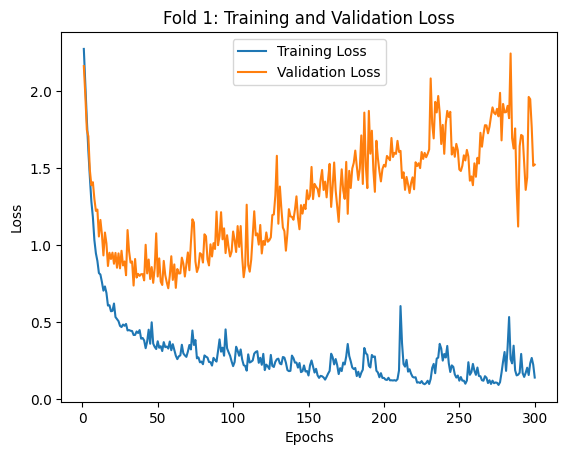

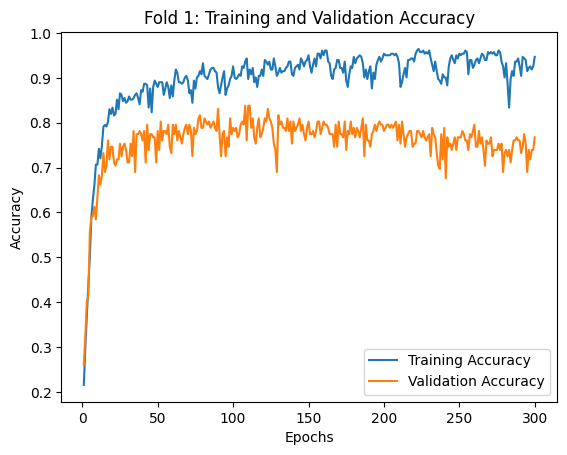

/Users/spartan/Documents/Information Security/Assignment 2/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Fold 2: Training Accuracy = 0.99, Testing Accuracy = 0.83


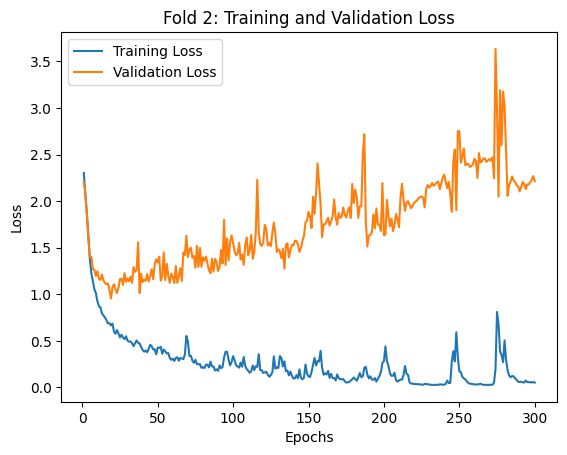

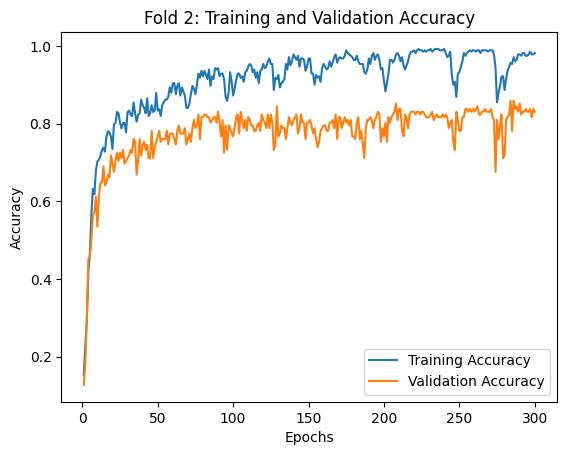

/Users/spartan/Documents/Information Security/Assignment 2/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold 3: Training Accuracy = 0.99, Testing Accuracy = 0.80


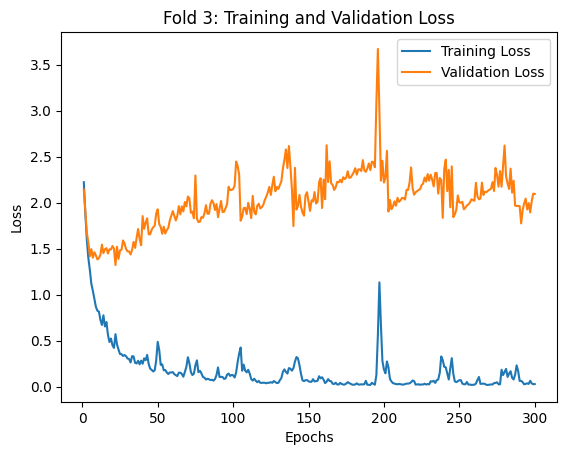

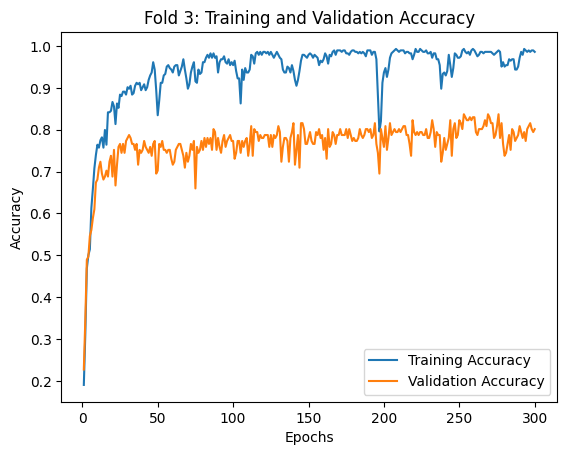


Average Training Accuracy: 0.98
Average Testing Accuracy: 0.80


In [50]:
import matplotlib.pyplot as plt

# Modify your training loop to capture the history
for fold, (train_index, test_index) in enumerate(kf.split(X_scaled), 1):
    # Split data into training and testing sets
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Create the model
    model = create_mlp(
        input_size=X_train.shape[1], 
        output_size=len(label_encoder.classes_), 
        hidden_layers=3, 
        neurons_per_layer=[10, 8, 5], 
        activation='relu'
    )
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.01),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model and capture the history
    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        epochs=300, 
                        batch_size=8, 
                        verbose=0)
    
    # Evaluate training accuracy
    train_accuracy = model.evaluate(X_train, y_train, verbose=0)[1]
    training_accuracies.append(train_accuracy)
    
    # Evaluate testing accuracy
    y_pred = np.argmax(model.predict(X_test), axis=1)
    test_accuracy = accuracy_score(y_test, y_pred)
    testing_accuracies.append(test_accuracy)
    
    # Print fold results
    print(f"Fold {fold}: Training Accuracy = {train_accuracy:.2f}, Testing Accuracy = {test_accuracy:.2f}")
    
    # Plot training loss and accuracy
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Plot Loss Curve
    plt.figure()
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold}: Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot Accuracy Curve
    plt.figure()
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {fold}: Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Report average accuracies
average_training_accuracy = np.mean(training_accuracies)
average_testing_accuracy = np.mean(testing_accuracies)
print(f"\nAverage Training Accuracy: {average_training_accuracy:.2f}")
print(f"Average Testing Accuracy: {average_testing_accuracy:.2f}")


<h3>Results</h3>

<h4>Outlier Removal</h4>
The dataset was cleaned using IsolationForest, removing 1% of rows identified as outliers.
<h4>Cross-Validation Accuracy</h4>
Fold-wise results:<br>
Fold 1: Training Accuracy = 90%, Testing Accuracy = 77%.<br>
Fold 2: Training Accuracy = 99%, Testing Accuracy = 80%.<br>
Fold 3: Training Accuracy = 99%, Testing Accuracy = 85%.<br>
Average Accuracy:<br>
Training: 96%.<br>
Testing: 81%.<br>
<h4>3. Visualizations</h4>
Loss Curves:
Training and validation loss curves for each fold demonstrate model convergence.<br>
Accuracy Curves:
Training and validation accuracy curves for each fold indicate the model's learning progress.
<h3>Conclusion</h3>

The MLP model achieves an average testing accuracy of 81%, indicating good generalization.